# Train and compare two NN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 30, 128)           2048      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 30, 64)            24640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 15, 32)            6176      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 32)           

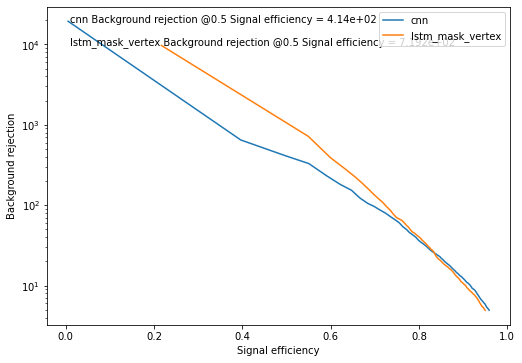

Wall time: 8min 20s


In [4]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Functions.Preprocess import events_to_df, events_to_df_vert1, scale_shift_feats, for_nn, for_nn_vert, tracks_to_df
from Functions.Models import cnn, lstm, lstm_big, train, lstm_mask
from Functions.Evaluate import compareAB, compareAB1

# General params
model_names = ["cnn","lstm_mask_vertex"]
max_ev = int(1e6)
val_frac = 0.2

### Model 1 preprocessing
# Params
n_constits = 30
sort = "D0"
feats = ["track_D0", "track_DZ"] + ["track_PT", "track_Eta", "track_Phi"] 
# Define model
model1 = cnn(n_constits, feats)
# Data paths
bkg_path = ["Data/from_cluster/bb{}.root.GetTracks.txt".format(i) for i in range(1,3)]
sig_path = ["Data/from_cluster/dark{}.root.GetTracks.txt".format(i) for i in range(1,3)]
bkg_path_test = ["Data/from_cluster/bb{}.root.GetTracks.txt".format(i) for i in range(3,4)]
sig_path_test = ["Data/from_cluster/dark{}.root.GetTracks.txt".format(i) for i in range(3,4)]
# To df
bkg_j = tracks_to_df(bkg_path, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort)
sig_j = tracks_to_df(sig_path, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort)
bkg_j_test = tracks_to_df(bkg_path_test, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort)
sig_j_test = tracks_to_df(sig_path_test, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort)
# Apply preprocessing
train_val = pd.concat([sig_j,bkg_j.loc[range(sig_j.shape[0])]]).sample(frac=1).reset_index()
scale_shift_feats(train_val)
scale_shift_feats(bkg_j_test)
scale_shift_feats(sig_j_test)
# To nn
X_train1, y_train1, X_val1, y_val1, X_test_B1, X_test_S1 = for_nn(train_val, bkg_j_test, sig_j_test, feats, n_constits, val_frac=0.2)

### Model 2 preprocessing
# Params
n_constits = 10
sort = 'vert_disp'
trunc = True
feats = ["vert_disp", "vert_mult", "vert_PT"]
# Define model
model2 = lstm_mask(n_constits, feats)
# Data paths
bkg_path = ["Data/from_cluster/bb{}.txt".format(i) for i in range(1,3)]
sig_path = ["Data/from_cluster/dark{}.txt".format(i) for i in range(1,3)]
bkg_path_test = ["Data/from_cluster/bb{}.txt".format(i) for i in range(3,4)]
sig_path_test = ["Data/from_cluster/dark{}.txt".format(i) for i in range(3,4)]
# To df
bkg_j = events_to_df_vert1(bkg_path, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
sig_j = events_to_df_vert1(sig_path, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
bkg_j_test = events_to_df_vert1(bkg_path_test, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
sig_j_test = events_to_df_vert1(sig_path_test, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
# Apply preprocessing
train_val = pd.concat([sig_j,bkg_j.loc[range(sig_j.shape[0])]]).sample(frac=1).reset_index()
# To nn
X_train2, y_train2, X_val2, y_val2, X_test_B2, X_test_S2 = for_nn(train_val, bkg_j_test, sig_j_test, feats, n_constits, val_frac=0.2)

print("num Background jets = {}".format(len(bkg_j)))
print("num Signal jets = {}".format(len(sig_j)))
print("num Background test jets = {}".format(len(bkg_j_test)))
print("num Signal test jets = {} \n".format(len(sig_j_test)))

# Train models
train(model1, X_train1, y_train1, X_val1, y_val1, model_names[0])
train(model2, X_train2, y_train2, X_val2, y_val2, model_names[1])

# Compare
compareAB1(model_names[0], model_names[1], X_test_B1, X_test_S1, X_test_B2, X_test_S2)